# SEC built functions

In [356]:
import requests
import json
import pandas as pd
from secedgar import CompanyFilings, FilingType
import streamlit as st
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as pls

import yfinance as yf
import datetime as dt


header = {'User-Agent':'gavinhurd11@gmail.com'}
tickers_cik = requests.get('https://www.sec.gov/files/company_tickers.json', headers = header)
tickers_cik = pd.json_normalize(pd.json_normalize(tickers_cik.json(), max_level=0).values[0])
tickers_cik['cik_str']=tickers_cik['cik_str'].astype(str).str.zfill(10)


selected_ticker = 'UG'
cik_str = tickers_cik['cik_str'][tickers_cik['ticker'] == selected_ticker].values[0]
cik_str

'0000101295'

In [71]:
#Company data
def EDGAR_query(cik:str, header:dict, tag:list=None)->pd.DataFrame:
    url = 'https://data.sec.gov/api/xbrl/companyfacts/CIK'+cik+'.json'
    response = requests.get(url, headers=header)

    try:
        if tag == None:
            tags = list(response.json()['facts']['us-gaap'].keys())
        else:
            tags=tag
        
        company_data = pd.DataFrame()


        for i in range(len(tags)):
            try:
                tag = tags[i]
                units = list(response.json()['facts']['us-gaap'][tag]['units'].keys())[0]
                data = pd.json_normalize(response.json()['facts']['us-gaap'][tag]['units'][units])
                data['tag']=tag
                data['units']=units
                company_data = pd.concat([company_data, data], ignore_index=True)
            except:
                print(tag+'not found')
    except:print('company data not found')
    return company_data

In [213]:
df = EDGAR_query(cik_str, header = header)

In [465]:
#Create variables for whatever tag name is used to describe raw, workinprocess, and finished
raw_tags = df['tag'][df['tag'].str.contains('rawmaterials', case = False)].unique()
raw_tag = min(raw_tags, key=len)

wip_tags = df['tag'][df['tag'].str.contains('workinprocess', case = False)].unique()
wip_tag = min(wip_tags, key=len)

fin_tags = df['tag'][df['tag'].str.contains('FinishedGoods', case = False)].unique()
fin_tag = min(fin_tags, key=len)

inc_tags = df['tag'][df['tag'].str.contains('netincome', case = False)].unique()
inc_tag = min(inc_tags, key=len)

In [466]:
df[["start", 'end']] = df[["start", 'end']].apply(pd.to_datetime, errors='coerce', utc=False)
df = df[df['frame'].notna() & df['frame'].notnull()]
df.sort_values(by='end', inplace = True) 
df.reset_index(inplace = True)

C:\Users\hurdg\AppData\Local\Temp\ipykernel_27360\2714733571.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [467]:

#Subset by desired data
df_inventory = df[df['tag'].isin([raw_tag, wip_tag, fin_tag, inc_tag])][['start','end','val','tag', 'frame']]
#df_inventory[["start", 'end']] = df_inventory[["start", 'end']].apply(pd.to_datetime, errors='coerce', utc=False)
#df_inventory = df_inventory[df_inventory['frame'].notna() & df_inventory['frame'].notnull()]
#df_inventory.sort_values(by='end', inplace = True) 
df_inventory.reset_index(inplace = True)

In [468]:
#Calculate 4th quarter data
inc_index = df_inventory[df_inventory['tag'] == inc_tag].index
delta = df_inventory.iloc[inc_index]['end'] - df_inventory.iloc[inc_index]['start']
annual_index = delta > dt.timedelta(345)

for i in inc_index[annual_index]:
    infile =  df_inventory.iloc[i]
    k_val = infile['val']
    k_enddate = infile['end']
    k_startdate = infile['start']

    quartervals = (df_inventory['val'].iloc[inc_index][(df_inventory['start'] >= k_startdate) & #Within time period defined by 10-k 
                                                         (df_inventory['end'] <= k_enddate) &
                                                         ((df_inventory['end'] - df_inventory['start']) < dt.timedelta(200))]) #Exclude the 10-k vlaue
    new_val = k_val - sum(quartervals)
    df_inventory['val'].iloc[i] = new_val

C:\Users\hurdg\AppData\Local\Temp\ipykernel_27360\3179933217.py:16: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\hurdg\AppData\Local\Temp\ipykernel_27360\3179933217.py:16: FutureWarning:

ChainedAssignmentError: behaviour will chan

In [473]:
df_hist = yf.Ticker(selected_ticker)
df_hist.info

# get historical market data
hist = df_hist.history(period="max")
hist.reset_index(inplace = True)
hist["Date"] = hist["Date"].dt.tz_localize(tz = None)
hist = hist[hist["Date"] > (min(df_inventory['start']))]

In [470]:
import plotly.graph_objects as go
import plotly.subplots as pls
#Create Figure
#######################
fig = go.Figure()
fig = pls.make_subplots(rows=1, cols=1,
                        specs=[[{"secondary_y": True}]])

fig.add_trace(go.Line(
    x = hist['Date'],
    y = hist['Close'],
    legendgroup="group", 
    legendgrouptitle_text="method one",
    line=dict(color='white', width = 0.1),
    name="Stock Price"
), row=1, col=1, secondary_y=True)

fig.add_trace(go.Bar(
    x = df_inventory['end'][df_inventory['tag']==raw_tag],
    y = df_inventory['val'][df_inventory['tag']==raw_tag],
    legendgroup="group",
    marker=dict(color='forestgreen'),
    legendgrouptitle_text="method one",
    name="Raw Materials"
), row=1, col=1, secondary_y=False)

fig.add_trace(go.Bar(
    x = df_inventory['end'][df_inventory['tag']==wip_tag],
    y = df_inventory['val'][df_inventory['tag']==wip_tag],
    legendgroup="group", 
    legendgrouptitle_text="method one",
    marker=dict(color='goldenrod'),
    name="Work In Process"
), row=1, col=1, secondary_y=False)

fig.add_trace(go.Bar(
    x = df_inventory['end'][df_inventory['tag']==fin_tag],
    y = df_inventory['val'][df_inventory['tag']==fin_tag],
    legendgroup="group", 
    legendgrouptitle_text="method one",
    marker=dict(color='darkred'),
    name="Finished Goods"
), row=1, col=1, secondary_y=False)

fig.add_trace(go.Line(
    x = df_inventory['end'][df_inventory['tag']=='NetIncomeLoss'],
    y = df_inventory['val'][df_inventory['tag']=='NetIncomeLoss']/10,
    legendgroup="group", 
    legendgrouptitle_text="method one",
    marker=dict(color='darkblue'),
    name="Net Income"
), row=1, col=1, secondary_y=False)

fig.update_layout(barmode='group', margin={"r": 0, "t": 0, "l": 0, "b": 0}, 
                  bargroupgap=0.1, plot_bgcolor='#0e1117', paper_bgcolor='#0e1117', autosize = True,
                  legend=dict(yanchor="top",y=0.99,xanchor="left",x=0.01))

c:\Users\hurdg\Documents\Investments\StreamLit_Dash\.venv\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\hurdg\Documents\Investments\StreamLit_Dash\.venv\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [605]:
newest_annual_dates = pd.Series.nlargest((df['end'][df['tag']==inc_tag]),4)
newest_profit = df['val'][(df['tag']==inc_tag) & (df['end'].isin(newest_annual_dates))]
newest_sharesoutstanding = df['val'][(df['tag']=='CommonStockSharesOutstanding') & (df['end']== max(newest_annual_dates))]
newest_profitpershare = newest_profit.sum()/newest_sharesoutstanding.mean()
newest_price = hist['Close'][hist["Date"]==max(hist["Date"])]
pe = round((newest_price/newest_profitpershare).mean(),2)

In [631]:
dates

<DatetimeArray>
['2009-12-31 00:00:00', '2010-06-30 00:00:00', '2010-09-30 00:00:00',
 '2010-12-31 00:00:00', '2011-03-31 00:00:00', '2011-06-30 00:00:00',
 '2011-09-30 00:00:00', '2011-12-31 00:00:00', '2012-03-31 00:00:00',
 '2012-06-30 00:00:00', '2012-09-30 00:00:00', '2012-12-31 00:00:00',
 '2013-03-31 00:00:00', '2013-06-14 00:00:00', '2013-06-30 00:00:00',
 '2013-09-30 00:00:00', '2013-12-31 00:00:00', '2014-03-31 00:00:00',
 '2014-06-13 00:00:00', '2014-06-30 00:00:00', '2014-09-30 00:00:00',
 '2014-12-22 00:00:00', '2014-12-31 00:00:00', '2015-03-31 00:00:00',
 '2015-06-15 00:00:00', '2015-06-30 00:00:00', '2015-09-30 00:00:00',
 '2015-12-15 00:00:00', '2015-12-31 00:00:00', '2016-03-31 00:00:00',
 '2016-06-15 00:00:00', '2016-06-30 00:00:00', '2016-09-30 00:00:00',
 '2016-12-19 00:00:00', '2016-12-31 00:00:00', '2017-03-31 00:00:00',
 '2017-06-12 00:00:00', '2017-06-30 00:00:00', '2017-09-30 00:00:00',
 '2017-12-18 00:00:00', '2017-12-31 00:00:00', '2018-03-31 00:00:00',
 '20

In [702]:
dates = df['end'].unique()

df['end'][df['tag']==inc_tag]
df['val'][df['tag']==inc_tag]
pe_list = []
date_list = []
for i in range(3,len(dates)):
    #Chunk data quarterly
    quarterly_prices = hist['Close'][(hist['Date'] > dates[i-1]) & (hist['Date'] < dates[i])]

    annualized_earning = df['val'][(df['tag']==inc_tag) & (df['end']< dates[i-1]) & (df['end']<dates[i-1]-dt.timedelta(360))].mean()*4
    quarterly_shares = df['val'][(df['tag']=='CommonStockSharesOutstanding') & (df['end']<dates[i-1]) & (df['end']<dates[i-1]-dt.timedelta(360))].max()
    quartely_earningspershare = annualized_earning/quarterly_shares
    quarterly_pe = quarterly_prices/quartely_earningspershare

    quarterly_dates = hist['Date'][(hist['Date'] > dates[i-1]) & (hist['Date'] < dates[i])]
    pe_list.append(quarterly_pe)
    date_list.append(quarterly_dates)


def flatten(xss):
    return [x for xs in xss for x in xs]

pe_df = pd.DataFrame({'date' : flatten(date_list),
              'pe' : flatten(pe_list)})


Series([], Name: val, dtype: float64)
Series([], Name: val, dtype: float64)
Series([], Name: val, dtype: float64)
6    624524.0
Name: val, dtype: float64
6      624524.0
25    1243785.0
Name: val, dtype: float64
6      624524.0
25    1243785.0
48    3799692.0
Name: val, dtype: float64
6       624524.0
25     1243785.0
48     3799692.0
117    1166183.0
Name: val, dtype: float64
6       624524.0
25     1243785.0
48     3799692.0
117    1166183.0
170    1224640.0
Name: val, dtype: float64
6       624524.0
25     1243785.0
48     3799692.0
117    1166183.0
170    1224640.0
190    1369283.0
Name: val, dtype: float64
6       624524.0
25     1243785.0
48     3799692.0
117    1166183.0
170    1224640.0
190    1369283.0
311    4716530.0
Name: val, dtype: float64
6       624524.0
25     1243785.0
48     3799692.0
117    1166183.0
170    1224640.0
190    1369283.0
311    4716530.0
342    1228630.0
Name: val, dtype: float64
6       624524.0
25     1243785.0
48     3799692.0
117    1166183.0
170   

In [703]:
labels = ["Price per Share", "Earnings per Share"]
values = [round(newest_price.mean(),2), round(newest_profitpershare.mean(),2)]

# Create subplots: use 'domain' type for Pie subplot
fig = pls.make_subplots(rows=2, cols=1, specs=[[{'type':'domain'}],[{'type':'xy'}]])
fig.add_trace(go.Pie(labels=labels, values=values, title=f"P/E <br> <b>{pe}</b>", 
                     title_font=dict(size=20, color = "white", family='Arial, sans-serif'),
                     hole=.4, hoverinfo="label+value+name",
                     marker=dict(colors=['darkred', 'red'], line=dict(color='#000000', width=2))), 
                row=1, col=1) 


fig.add_trace(go.Line(
    x = pe_df['date'],
    y = pe_df['pe'],
    marker=dict(color='darkblue'),
    name="Net Income"
), row=2, col=1)

fig.update_layout(
    title_text="",
    showlegend=False,
    margin={"r": 0, "t": 0, "l": 0, "b": 0}, plot_bgcolor='#0e1117', paper_bgcolor='#0e1117', autosize = True)
fig.show()

c:\Users\hurdg\Documents\Investments\StreamLit_Dash\.venv\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [678]:
pe_df

,date,pe
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
3400,72.628143,72.628143
3401,72.143950,72.143950
3402,71.175578,71.175578
3403,72.143950,72.143950


In [597]:
10000/200





50.0

In [61]:
x_raw = df['frame'][df['tag'] == 'InventoryRawMaterials']
y_raw = df['val'][df['tag'] == 'InventoryRawMaterials']

x_inprog = df['frame'][df['tag'] == 'InventoryWorkInProcess']
y_inprog = df['val'][df['tag'] == 'InventoryWorkInProcess']

x_finish = df['frame'][df['tag'] == 'InventoryFinishedGoods']
y_finish = df['val'][df['tag'] == 'InventoryFinishedGoods']

In [ ]:
def make_groupedbar(input_x, input_y):
    px.bar(
    x = input_x
    y = input_y,
    opacity = 0.9,
    orientation = "v",
    barmode = 'group',
    title='Annual In-State Tuition vs Out-of-state Tuition',
)

In [73]:
df['val'][df['tag'] == 'InventoryRawMaterials']

Series([], Name: val, dtype: float64)

In [67]:
input_x = x_raw
input_y = y_raw

px.bar(x = input_x,
    y = input_y,
    opacity = 0.9,
    orientation = "v",
    barmode = 'group',
    title='Annual In-State Tuition vs Out-of-state Tuition',
)

ValueError: Cannot accept list of column references or list of columns for both `x` and `y`.

In [55]:
def extract_name(json_str):
    json_data = json.loads(json_str)
    return json_data.get('name')

df['category2'] = df['category'].apply(extract_name)

Index(['end', 'val', 'accn', 'fy', 'fp', 'form', 'filed', 'frame', 'tag',
       'units', 'start'],
      dtype='object')

# Basic Python with SEC Edgar API


In [1]:
import requests
import json
import pandas as pd
import time
from secedgar import CompanyFilings, FilingType

header = {'User-Agent':'gavinhurd11@gmail.com'}
tickers_cik = requests.get('https://www.sec.gov/files/company_tickers.json', headers = header)
tickers_cik = pd.json_normalize(pd.json_normalize(tickers_cik.json(), max_level=0).values[0])
tickers_cik['cik_str']=tickers_cik['cik_str'].astype(str).str.zfill(10)


In [6]:
tickers_cik['cik_str'][tickers_cik['ticker'] == 'AAPL']

1    0000320193
Name: cik_str, dtype: object

In [2]:
#List of possible 'tags'
header = {'User-Agent':'gavinhurd11@gmail.com'}
example_cik=tickers_cik['cik_str'][0]
url = 'https://data.sec.gov/api/xbrl/companyfacts/CIK'+example_cik+'.json'
response_example = requests.get(url, headers=header)
possible_tags = list(response_example.json()['facts']['us-gaap'].keys())

In [4]:
def EDGAR_query(cik:str, header:dict, tag:list=None)->pd.DataFrame:
    url = 'https://data.sec.gov/api/xbrl/companyfacts/CIK'+cik+'.json'
    response = requests.get(url, headers=header)

    try:
        if tag == None:
            tags = list(response.json()['facts']['us-gaap'].keys())
        else:
            tags=tag
        
        company_data = pd.DataFrame()


        for i in range(len(tags)):
            try:
                tag = tags[i]
                units = list(response.json()['facts']['us-gaap'][tag]['units'].keys())[0]
                data = pd.json_normalize(response.json()['facts']['us-gaap'][tag]['units'][units])
                data['tag']=tag
                data['units']=units
                company_data = pd.concat([company_data, data], ignore_index=True)
            except:
                print(tag+'not found')
    except:print('company data not found')
    return company_data


In [9]:
EDGAR_data = pd.DataFrame()

for i in range(len(tickers_cik)):
#for i in [10,11,12,13]:
    cik=tickers_cik['cik_str'][i]
    ticker = tickers_cik['ticker'][i]
    title = tickers_cik['title'][i]

    #company_data = EDGAR_query(cik=cik, tag = ["RevenueFromContractWithCustomerExcludingAssessedTax"], header=header)
    try:
        company_data = EDGAR_query(cik=cik, header=header)
        company_data['cik'] = cik
        company_data['ticker']= ticker
        company_data['title'] = title
    
        #Filter quarterly
        try:
            company_data= company_data[company_data['frame'].str.contains('Q') == True]
        except:
            print('frame not a column')
        
        EDGAR_data=pd.concat([EDGAR_data, company_data], ignore_index=True)
        print(i)
    except:
        print("company datat not found again")
    time.sleep(0.015)

#EDGAR_data.to_csv('EDGAR_data.csv')

0
1
2
3
4
5
6
7
8
9
10
company data not found
company datat not found again
12
13
company data not found
company datat not found again
company data not found
company datat not found again
16
17
company data not found
company datat not found again
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
company data not found
company datat not found again
37
company data not found
company datat not found again
39
company data not found
company datat not found again
company data not found
company datat not found again
42
43
44
45
46
47
company data not found
company datat not found again
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
company data not found
company datat not found again
company data not found
company datat not found again
66
67
68
69
70
71
72
73
74
company data not found
company datat not found again
76
77
78
79


C:\Users\hurdg\AppData\Local\Temp\ipykernel_88304\2041124615.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  company_data = pd.concat([company_data, data], ignore_index=True)


80
81
82
company data not found
company datat not found again
company data not found
company datat not found again
85
86
87
88
89
company data not found
company datat not found again
91
company data not found
company datat not found again
93
company data not found
company datat not found again
95
company data not found
company datat not found again
97
98
99
100
101
102
103
104
105
106
company data not found
company datat not found again
108
109


C:\Users\hurdg\AppData\Local\Temp\ipykernel_88304\2041124615.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  company_data = pd.concat([company_data, data], ignore_index=True)
C:\Users\hurdg\AppData\Local\Temp\ipykernel_88304\2041124615.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  company_data = pd.concat([company_data, data], ignore_index=True)
C:\Users\hurdg\AppData\Local\Temp\ipykernel_88304\2041124615.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all

110
111
112
company data not found
company datat not found again
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
FinanceLeaseLiabilityNoncurrentnot found
130
company data not found
company datat not found again
132
133
134
company data not found
company datat not found again
company data not found
company datat not found again
137
138
139
140
141
company data not found
company datat not found again
143
144
145
company data not found
company datat not found again
147
company data not found
company datat not found again
149
company data not found
company datat not found again
151
152
153
154
155
company data not found
company datat not found again
company datat not found again
company data not found
company datat not found again
company data not found
company datat not found again


C:\Users\hurdg\AppData\Local\Temp\ipykernel_41028\111270565.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AAPL_netinc['frame'] = AAPL_netinc['frame'].str.replace('CY','')
C:\Users\hurdg\AppData\Local\Temp\ipykernel_41028\111270565.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AAPL_netinc['val_billions']=AAPL_netinc['val']/1000000000


AttributeError: 'Axes' object has no attribute 'show'

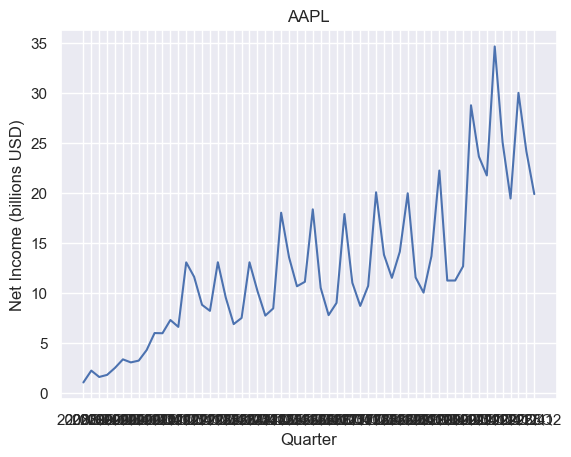

In [25]:
#EDGAR_data = pd.read_csv('EDGAR_data.csv')
AAPL_data = EDGAR_data[EDGAR_data['ticker']=='AAPL'].copy()
AAPL_netinc = AAPL_data[AAPL_data['tag']=='NetIncomeLoss']
AAPL_netinc['frame'] = AAPL_netinc['frame'].str.replace('CY','')
AAPL_netinc['val_billions']=AAPL_netinc['val']/1000000000

sns.set_theme(style='darkgrid')
fig=sns.lineplot(data=AAPL_netinc, x='frame', y='val_billions')
fig.set(xlabel='Quarter', ylabel='Net Income (billions USD)', title='AAPL')
fig.show()

## Dashboard

In [28]:
import pandas as pd
import plotly.express as px

In [62]:
EDGAR_data = pd.read_csv('EDGAR_data_alltags.csv')

AAPL_data = EDGAR_data[(EDGAR_data['ticker'] =='MSFT') | (EDGAR_data['ticker'] =='AAPL')].copy()
AAPL_netinc = AAPL_data[AAPL_data['tag']=='NetIncomeLoss']
AAPL_netinc['frame'] = AAPL_netinc['frame'].str.replace('CY','')
AAPL_netinc['val_billions']=AAPL_netinc['val']/1000000000

px.line(AAPL_netinc, x='frame', y='val_billions', color = 'ticker')

C:\Users\hurdg\AppData\Local\Temp\ipykernel_41028\117602065.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hurdg\AppData\Local\Temp\ipykernel_41028\117602065.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1]:
from dash import Dash
from dash_bootstrap_components.themes import BOOTSTRAP

from src.components.layout import create_layout


def main() -> None:
    app = Dash(external_stylesheets=[BOOTSTRAP])
    app.title = "Medal dashboard"
    app.layout = create_layout(app)
    app.run()


if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'src'

# With SEC-API module
subscription required

In [ ]:
#SEC.io
#https://medium.com/@jan_5421/extracting-financial-statements-from-sec-filings-xbrl-to-json-f83542ade90

import requests
import json
import pandas as pd

# 10-Q filing URL of Apple
filing_url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000056/aapl-20210327.htm"

# XBRL-to-JSON converter API endpoint
xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"

# get your API key at https://sec-api.io
api_key = "84095f4d03ac1fae2dfb5832934d211c6f4db7f24a2985cd0bd4f37f0d976458"

final_url = xbrl_converter_api_endpoint + "?htm-url=" + filing_url + "&token=" + api_key

# make request to the API
response = requests.get(final_url)

# load JSON into memory
xbrl_json = json.loads(response.text)

# income statement example
print(xbrl_json['StatementsOfIncome'])

In [ ]:
# convert XBRL-JSON of income statement to pandas dataframe
def get_income_statement(xbrl_json):
    income_statement_store = {}

    # iterate over each US GAAP item in the income statement
    for usGaapItem in xbrl_json['StatementsOfIncome']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfIncome'][usGaapItem]:
            # only consider items without segment. not required for our analysis.
            if 'segment' not in fact:
                index = fact['period']['startDate'] + '-' + fact['period']['endDate']
                # ensure no index duplicates are created
                if index not in indicies:
                    values.append(fact['value'])
                    indicies.append(index)                    

        income_statement_store[usGaapItem] = pd.Series(values, index=indicies) 

    income_statement = pd.DataFrame(income_statement_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date range
    return income_statement.T 

income_statement = get_income_statement(xbrl_json)

First, we use the query API provided by SEC API to list all most recent 10-Q and 10-K filings filed by Apple.


In [ ]:
from sec_api import QueryApi

api_key = "84095f4d03ac1fae2dfb5832934d211c6f4db7f24a2985cd0bd4f37f0d976458"
ticker = "AAPL"

# get your API key at https://sec-api.io
query_api = QueryApi(api_key=api_key)


# fetch all 10-Q and 10-K filings for Apple
query = {
    "query": {
        "query_string": {
            "query": f"(formType:\"10-Q\" OR formType:\"10-K\") AND ticker:{ticker}"
        }
    },
    "from": "0",
    "size": "20",
    "sort": [{ "filedAt": { "order": "desc" } }]
}

query_result = query_api.get_filings(query)

Then, we extract all accession numbers of each filing.

In [ ]:
accession_numbers = []

# extract accession numbers of each filing
for filing in query_result['filings']:
    accession_numbers.append(filing['accessionNo']);


Now we define a helper function to get the XBRL-JSON version of a filing by providing its accession number. We add a simple backoff strategy to our helper to avoid overloading the SEC API with too many requests per second. In case we send too many requests and the response fails, we just wait for 500 milliseconds and retry the same request. That’s helpful when we download multiple quarterly and annual statements back to back so that we can merge them into one big statement.

In [ ]:
import time

# get XBRL-JSON for a given accession number
def get_xbrl_json(accession_no, retry = 0):
    request_url = xbrl_converter_api_endpoint + "?accession-no=" + accession_no + "&token=" + api_key

    # linear backoff in case API fails with "too many requests" error
    try:
      response_tmp = requests.get(request_url)
      xbrl_json = json.loads(response_tmp.text)
    except:
      if retry > 5:
        raise Exception('API error')
      
      # wait 500 milliseconds on error and retry
      time.sleep(0.5) 
      return get_xbrl_json(accession_no, retry + 1)

    return xbrl_json

Next, we define a function to merge two income statement dataframes into one. We use this merge function to iterate over all 10-K and 10-Q income statements and generate one, large income statement holding all values.

In [ ]:
# merge two income statements into one statement.
# row indicies of both statements have to be the same
# statement_b represents the most recent statement.
def merge_income_statements(statement_a, statement_b):
    return statement_a.merge(statement_b,
                     how="outer", 
                     on=statement_b.index, 
                     suffixes=('_left', ''))

The cleaning function helps us removing columns we are not interested in, for example columns holding more than 5 NaN values or columns ending with “_left”. The merge function creates a column ending with “_left” if it’s a duplicate column. We also rearrange the columns so that the most recent quarter column sits right and the oldest quarter left.

In [ ]:
# clean income statement.
# drop duplicate columns (= column name ends with "_left"), drop key_0 column, drop columns with +5 NaNs
def clean_income_statement(statement):
    for column in statement:

        # column has more than 5 NaN values
        is_nan_column = statement[column].isna().sum() > 5

        if column.endswith('_left') or column == 'key_0' or is_nan_column:
            statement = statement.drop(column, axis=1)
    
    # rearrange columns so that first column represents first quarter
    # e.g. 2018, 2019, 2020 - and not 2020, 2019, 2018
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

Finally it’s time to build our multi-year income statement. We iterate over all accession numbers, generate the XBRL-JSON version, create an income statement dataframe and merge the newly generated income statement with our global statement. All 10-Q and 10-K income statements are now merged into a single pandas dataframe.

In [ ]:
# helps printing dataframes while we generate new income statement
from IPython.display import display, HTML

previous_income_statement_set = False
income_statement_final = None

for accession_no in accession_numbers[0:9]:
# for accession_no in accession_numbers: # doesn't work with filings filed before 2017 - indicies not equal
    print(accession_no)
    
    # get XBRL-JSON of 10-Q or 10-K filing by accession number
    xbrl_json_data = get_xbrl_json(accession_no)
    
    # convert XBRL-JSON to a pandas dataframe
    income_statement_uncleaned = get_income_statement(xbrl_json_data)

    # clean the income statement
    income_statement_cleaned = clean_income_statement(income_statement_uncleaned)
    
    # print income statement on each iteration to monitor progress
    #display(HTML(income_statement_cleaned.to_html()))
    
    # merge new income statement with previously generated income statement
    if previous_income_statement_set:
        income_statement_final = clean_income_statement(merge_income_statements(income_statement_final, income_statement_cleaned))
    else:
        income_statement_final = income_statement_cleaned
        previous_income_statement_set = True

Looking closely we see that 4th quarter results are missing. That’s expected because a company only files three times per year a 10-Q filing and once per year a 10-K filing. It’s on us now to calculate the 4th quarter results by using the annual and 9-month results.

We start by defining a number converter function. Either we convert a given string to an integer (e.g. net income) or to a float (e.g. earnings per share).

The main function iterates over all columns. The function checks if the column represents an annual result (delta.days > 350). If it’s an annual result column, we iterate over all columns and find the column that represents 9-month results starting at the same date as the annual results column.

Once discovered, we calculate the 4th quarter results by simply subtracting the 9-month result of a US GAAP item from its annual result.

For example:
Net Income (4th Quarter) =
Net Income (Annually) — Net Income (9-Months)

This doesn’t work for Earnings Per Share and Number Of Shares Outstanding. That’s why we calculate such values using the newly calculated values.

For example:
EarningsPerShareBasic (4th Quarter) =
NetIncomeLoss (4th Quarter) / WeightedAverageNumberOfSharesOutstandingBasic (4th Quarter)

In [ ]:
from datetime import datetime

# convert string to int or float
def num(string):
    try:
        return int(string)
    except ValueError:
        return float(string)
    
# calculate 4th quarter results
# 4th quarter results are not reported seperately and have to be calculated using yearly and 9-month results
def add_fourth_quarter_results(statement):
    for column in statement:

        # ['2018', '09', '30', '2019', '09', '28']
        date_strings = [a for a in column.split('-')] 

        d0 = datetime.strptime(date_strings[0] + date_strings[1] + date_strings[2], '%Y%m%d')
        d1 = datetime.strptime(date_strings[3] + date_strings[4] + date_strings[5], '%Y%m%d')

        delta = d1 - d0

        # is annual results column
        if delta.days > 350:
            for column_1 in statement:
                date_strings_1 = [a for a in column_1.split('-')]

                d1_0 = datetime.strptime(date_strings_1[0] + date_strings_1[1] + date_strings_1[2], '%Y%m%d')
                d1_1 = datetime.strptime(date_strings_1[3] + date_strings_1[4] + date_strings_1[5], '%Y%m%d')

                delta_1 = d1_1 - d1_0

                # same starting month and 9-month results
                # calculate 4th quarter
                if d1_0 == d0 and delta_1.days > 200 and delta_1.days < 350:
                    fourth_quarter_column_name = column_1[11:] + column[10:]

                    fourth_quarter_values = []

                    for row_key, row_value in statement[column].iteritems():
                        value = num(statement[column][row_key]) - num(statement[column_1][row_key])
                        
                        if isinstance(value, float):
                            value = round(value, 2)
            
                        fourth_quarter_values.append(str(value))

                    statement[fourth_quarter_column_name] = fourth_quarter_values
 
                    # Calculate correct values of
                    # WeightedAverageNumberOfSharesOutstandingBasic = use value of annual result
                    # WeightedAverageNumberOfDilutedSharesOutstanding = use value of annual result
                    # EarningsPerShareBasic = NetIncomeLoss / WeightedAverageNumberOfSharesOutstandingBasic
                    # EarningsPerShareDiluted = NetIncomeLoss / WeightedAverageNumberOfDilutedSharesOutstanding
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"] = statement[column]["WeightedAverageNumberOfSharesOutstandingBasic"]
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"] = statement[column]["WeightedAverageNumberOfDilutedSharesOutstanding"]

                    statement[fourth_quarter_column_name]["EarningsPerShareBasic"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"]), 2)
                    
                    statement[fourth_quarter_column_name]["EarningsPerShareDiluted"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"]), 2)
                
    # sort columns
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

In [ ]:
statement = income_statement_final
for column in statement:

        # ['2018', '09', '30', '2019', '09', '28']
        date_strings = [a for a in column.split('-')] 

        d0 = datetime.strptime(date_strings[0] + date_strings[1] + date_strings[2], '%Y%m%d')
        d1 = datetime.strptime(date_strings[3] + date_strings[4] + date_strings[5], '%Y%m%d')

        delta = d1 - d0

        # is annual results column
        if delta.days > 350:
            for column_1 in statement:
                date_strings_1 = [a for a in column_1.split('-')]

                d1_0 = datetime.strptime(date_strings_1[0] + date_strings_1[1] + date_strings_1[2], '%Y%m%d')
                d1_1 = datetime.strptime(date_strings_1[3] + date_strings_1[4] + date_strings_1[5], '%Y%m%d')

                delta_1 = d1_1 - d1_0

                # same starting month and 9-month results
                # calculate 4th quarter
                if d1_0 == d0 and delta_1.days > 200 and delta_1.days < 350:
                    fourth_quarter_column_name = column_1[11:] + column[10:]

                    fourth_quarter_values = []

                    for row_key, row_value in statement[column].items():
                        value = num(statement[column][row_key]) - num(statement[column_1][row_key])
                        
                        if isinstance(value, float):
                            value = round(value, 2)
            
                        fourth_quarter_values.append(str(value))

                    statement[fourth_quarter_column_name] = fourth_quarter_values
 
                    # Calculate correct values of
                    # WeightedAverageNumberOfSharesOutstandingBasic = use value of annual result
                    # WeightedAverageNumberOfDilutedSharesOutstanding = use value of annual result
                    # EarningsPerShareBasic = NetIncomeLoss / WeightedAverageNumberOfSharesOutstandingBasic
                    # EarningsPerShareDiluted = NetIncomeLoss / WeightedAverageNumberOfDilutedSharesOutstanding
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"] = statement[column]["WeightedAverageNumberOfSharesOutstandingBasic"]
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"] = statement[column]["WeightedAverageNumberOfDilutedSharesOutstanding"]

                    statement[fourth_quarter_column_name]["EarningsPerShareBasic"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"]), 2)
                    
                    statement[fourth_quarter_column_name]["EarningsPerShareDiluted"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"]), 2)

In [ ]:
for column in income_statement_final.items():
    display(column)

In the last step we remove all columns not representing quarterly results.

In [ ]:
def only_quarterly_results(statement):
    for column in statement:
        # convert all strings to int
        date_strings = [a for a in column.split('-')]

        d0 = datetime.strptime(date_strings[0] + date_strings[1] + date_strings[2], '%Y%m%d')
        d1 = datetime.strptime(date_strings[3] + date_strings[4] + date_strings[5], '%Y%m%d')
        delta = d1 - d0

        # column represents more timeframe longer than one quarter
        if delta.days > 100:
            statement = statement.drop(column, axis=1)
    return statement

## Plotting
Let’s have fun and plot revenues, net income and earnings per share.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import numpy as np

# custom y axis formatter
def format_dollars(y, pos=None):
    return int(y/1000000000)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = qrt_income_statement.astype(float)\
                         .loc["NetIncomeLoss"]\
                         .plot.line(legend=True)
ax = qrt_income_statement.astype(float)\
                         .loc["RevenueFromContractWithCustomerExcludingAssessedTax"]\
                         .plot.line(legend=True)

ax.set_title('Quarterly Revenues and Net Income')

ax.yaxis.set_major_formatter(tick.FuncFormatter(format_dollars))

plt.ylabel('$ Billions')

# show all quarter date ranges
plt.xticks(ticks=np.arange(len(qrt_income_statement.columns)),
           labels=qrt_income_statement.columns)

# format x axis properly
fig.autofmt_xdate()

plt.show()